## Training: Fitness Function

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.surrogate_model import *
from src.data.ff_dataloader import *
from src.preprocessing.transform_into_model_data_ff import *

#### Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

#### Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetFF(train=True, path="data/fitness_function")
test_dataset = DatasetFF(train=False, path="data/fitness_function")

In [4]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0636, -0.5317, -0.1259],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0636, -0.5318, -0.1259],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0636, -0.5317, -0.1259],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0673, -0.1535, -0.7162],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0673, -0.1535, -0.7162],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0673, -0.1535, -0.7162]])

In [5]:
train_dataset.y

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 1., 1., 0.],
        ...,
        [0., 0., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 0.]])

#### Scale training and test data

In [6]:
scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
scaler.fit(train_dataset.X[:, FEATURE_ID_TO_SCALE])
train_dataset.scale(scaler)
test_dataset.scale(scaler)

In [7]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  2.4552, -1.2641, -0.3551],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4552, -1.2641, -0.3551],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4552, -1.2641, -0.3551],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4639, -0.3579, -1.9267],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4639, -0.3579, -1.9267],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4639, -0.3579, -1.9267]])

#### Build model and switch to GPU if available

In [8]:
fitness_function = FitnessFunction(hidden_sizes=[120,100,100,100,100])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=120, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (out): Linear(in_features=100, out_features=4, bias=True)
)

In [9]:
fitness_function(test_dataset.X[0])

tensor([0.5070, 0.4891, 0.4862, 0.4895], grad_fn=<SigmoidBackward>)

#### Define loss function and optimizer

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### Define Data loaders

In [11]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### Model training

In [12]:
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    if (it + 1) % 1 == 0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

RuntimeError: 1D target tensor expected, multi-target not supported

#### Plot the train loss and test loss per iteration

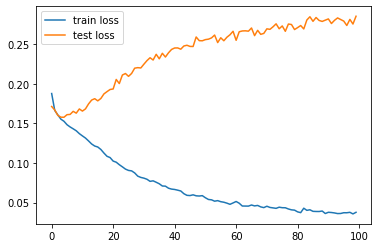

In [19]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

#### Save trained model

In [18]:
torch.save(fitness_function.state_dict(), "../models/best_fitness_function.pth")

#### Load model and make predictions

In [29]:
model = FitnessFunction(hidden_sizes=[98, 69])
model.load_state_dict(torch.load("../models/best_fitness_function.pth"))
model.eval()

FitnessFunction(
  (hidden): ModuleList(
    (0): Linear(in_features=360, out_features=245, bias=True)
  )
  (out): Linear(in_features=245, out_features=5, bias=True)
)

In [28]:
random_input = torch.from_numpy(np.random.normal(size=[1, 98]).astype(np.float32))

output = model(random_input)

tensor([[ 0.0636, -2.3131,  0.8815, -0.8085, -0.2552]],
       grad_fn=<AddmmBackward>)


tensor(2)

In [ ]:
output

In [ ]:
decode_classes(output)